<a href="https://colab.research.google.com/github/fabiocceruti/Churn_Prediction_ML/blob/main/Churn_Prediction_para_uma_empresa_de_Telecomunica%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
![](https://raw.githubusercontent.com/fabiocceruti/Portfolio/main/Banner_Principal_Ajustado.png)

[Designed by starline / Freepik](https://www.freepik.com/)

##**Análise de Dados da COVID-19 sob uma perspectiva mundial e brasileira**##


**By: [Fabio Ceruti](https://www.linkedin.com/in/fabio-ceruti/)**

[GitHub](https://github.com/fabiocceruti) | [LinkedIn](https://www.linkedin.com/in/fabio-ceruti/) | [Medium](https://fabiocceruti.medium.com/) 

**OBS: Para melhor visualização do projeto recomendo o visualizar dentro do ambiente do [Google Colab](https://colab.research.google.com/)**

---

# Churn Prediction

*Churn rate*, ou simplesmente *churn*, representa a taxa de evasão da sua base de clientes. Em serviços como Spotify ou Netflix, ela representaria a taxa de cancelamento de assinaturas.

<p align=center>
<img src="https://raw.githubusercontent.com/carlosfab/dsnp2/master/img/churnrate.jpg" width="60%"></p>

Ela é de extrema importância para a administração e sua análise ao longo do tempo pode mostrar que existe algum problema que deve ser atacado.

*Churn* também pode ser usado para identificar potenciais cancelamentos, com um tempo de antecedência, e promover ações direcionadas para tentar reter tais clientes. Essa métrica deve receber atenção pelo fato de que o Custo de Aquisição de Cliente (CAC) é normalmente mais alto que o custo para mantê-los. Ou seja, um alto valor para o *churn rate* é o que não desejamos.

## Aquisição dos Dados

Os dados utilizados neste projeto foram originalmente disponibilizados na [plataforma de ensino da IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#), e tratam de um problema típico de uma companhia de telecomunicações. O *dataset* completo pode ser encontrado [neste link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Dicionário de variáveis:
 * customerID - Código de identificação do consumidor;
 * gender - Gênero do consumidor;
 * SeniorCitizen - Consumidor aposentado;
 * Partner - Cliente casado;
 * tenure - Quantos meses a pessoa é cliente da empresa;
 * PhoneService - Possui serviço telefônico;
 * MultipleLines - Possui múltiplas linhas telefônicas;
 * InternetService - Qual provedor de serviço de internet;
 * OnlineSecurity - Possui serviço de segurança online;
 * OnlineBackup - Possui serviço de backup online atividado; 
 * DeviceProtection - does the client have equipment insurance (Yes, No, No internet service)
 * TechSupport - Possui serviço de suporte técnico ativdado; 
 * StreamingTV - Possui streaming de TV ativado; 
 * StreamingMovies - Possui serviço de streaming de Filmes ativado;
 * Contract - Tipo do contrato do consumidor; 
PaperlessBilling - Cliente utiliza faturamento sem papel; 
 * PaymentMethod - Método de pagamento;
 * MonthlyCharges - Pagamento mensal atual;
 * TotalCharges - Valor total que o cliente pagou pelos serviços durante todo o tempo;
 * Churn - Cliente abandonou o serviço.

O próximo passo é importar as bibliotecas necessárias para o projeto e carregar o dataset.


In [84]:
# importar os pacotes necessários
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, plot_confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
import numpy as np

#Ignorando warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [2]:
# importar os dados
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)


## Análise explorátoria dos dados

Este passo é importante para entendermos a estrutura do dataset e identificarmos se é necessário realizarmos alguma correção nos dados.

O primeiro passo é verificarmos a quantidade de dados e variáveis que existem no dataset.

In [3]:
#Imprimindo a quantidade de dados e variáveis
print("Quantidade de dados:", df.shape[0])
print("Quantidade de variáveis:", df.shape[1])

Quantidade de dados: 7043
Quantidade de variáveis: 21


Vamos avaliar o 5 primeiros e últimos dados.

In [4]:
#Imprimindo os 5 primeiros dados
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
#Imprimindo os 5 últimos dados
df.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


O próximo passo é avaliarmos como estão estruturados as variáveis com o intuito de entendermos os tipos de cada variável (categórica e numérica), se existe valores ausentes no banco de dados e etc.

Para facilitar esta visualização, vamos criar uma função que transforma as informações das variáveis em um dataframe.

In [6]:
def Map_Var_DF (features, df):
  #Criando um dicionário para receber as variáveis
  dict_var = {"feature": [],
              "Tipo": [],
              "Categórico": [],
              "Binário": [],
              "Valores Categóricos": [],
              "Min": [],
              "Max": [],
              "Qtd de Nulos": []}

  #Criando um loop a partir das features
  for feature in features:

    #Armazenando o nome da feature
    dict_var['feature'].append(feature)

    #Armazenando o tipo da variável
    dict_var['Tipo'].append(df[feature].dtypes)

    #Armazenando os valores mínimos
    dict_var['Min'].append(df[feature].min())

    #Armazenando os valores máximos
    dict_var['Max'].append(df[feature].max())

    #Armazenando a quantidade de valores nulos
    dict_var['Qtd de Nulos'].append(df[feature].isnull().sum())

    if ((df[feature].dtype == "O") or (df[feature].nunique() == 2)) and (feature != "TotalCharges"):

      #Atribuindo o valor 1 se a variável for categórica
      dict_var['Categórico'].append(1)

      #Armazenando os valores categóricos
      dict_var['Valores Categóricos'].append(df[feature].value_counts().index.to_list())

      if (df[feature].nunique() == 2):

        #Atribuindo o valor 1 se a variável for binária
        dict_var['Binário'].append(1)
        
      else:

        #Atribuindo o valor 0 se a variável não for binária
        dict_var['Binário'].append(0)

    else:

      #Atribuindo o valor 0 se a variável não for categórica
      dict_var['Categórico'].append(0)

      #Armazenando os valores categóricos
      dict_var['Valores Categóricos'].append(["N/A"])

      #Atribuindo o valor 0 se a variável não for binária
      dict_var['Binário'].append(0)
      
  #Transformando o dicionário em dataframe
  df_var = pd.DataFrame.from_dict(data = dict_var)

  #Imprimindo o dataframe
  return df_var

Vamos criar o dataframe das features do dataset. 

Vale destacar que não consideramos a variável **customerID**, porque não agrega valor no nosso modelo de Machine Learning e na análise exploratória, já que serve para identificar um consumidor de forma individual.

In [7]:
#Armazenando os nomes das variáveis
features = df.columns.to_list()

#Removendo a feature 'CustomerID'
features.remove('customerID')

#Dataframe da variável
df_var = Map_Var_DF(features = features, df = df)

#Imprimindo o dataframe
df_var

,feature,Tipo,Categórico,Binário,Valores Categóricos,Min,Max,Qtd de Nulos
0,gender,object,1,1,"[Male, Female]",Female,Male,0
1,SeniorCitizen,int64,1,1,"[0, 1]",0,1,0
2,Partner,object,1,1,"[No, Yes]",No,Yes,0
3,Dependents,object,1,1,"[No, Yes]",No,Yes,0
4,tenure,int64,0,0,[N/A],0,72,0
5,PhoneService,object,1,1,"[Yes, No]",No,Yes,0
6,MultipleLines,object,1,0,"[No, Yes, No phone service]",No,Yes,0
7,InternetService,object,1,0,"[Fiber optic, DSL, No]",DSL,No,0
8,OnlineSecurity,object,1,0,"[No, Yes, No internet service]",No,Yes,0
9,OnlineBackup,object,1,0,"[No, Yes, No internet service]",No,Yes,0


A partir do dataframe gerado pelas informações das features do dataset, podemos notar que:
* Maior parte das features são do tipo categórica. É importante ressaltar que a variável binária também é do tipo categórica. Portanto, estas variáveis deverão passar por um tratamento para serem convertidas em valores numéricos antes de aplicar o modelo de Machine Learning;
* Podemos converter os valores "No internet service" e "No phone service" em "No", transformando as variáveis em binárias, já que a partir de outras variáveis é possível transmitir a mesma informação; 
* Não temos valores ausentes, o que é um ponto positivo;
* A variável **TotalCharges** está classificada como string ao invés de float e podemos notar que seu valor mínimo está com aspas vazias (" "). Portanto, vamos ter que avaliar uma forma de substituir estes valores com aspas por numéricos e converter esta variável para float;
* A variável **SeniorCitizen**, apesar de estar classificada como inteiro, pode ser considerada como categórica, já que está tratada e possui dois valores numéricos para representar se o consumidor está aposentado (1) ou não (0);
* **Churn** é a variável alvo que queremos predizer através do modelo de Machine Learning.

O próximo passo é realizarmos este tratamento.

Vamos realizar a conversão dos valores "No internet service" e "No phone service" em "No", transformando as variáveis em binárias.

In [8]:
#Copiando o dataframe
df_trat = df.copy()

#Armazenando as variáveis categóricas
cat_features = df_var["feature"].loc[ df_var["Categórico"] == 1 ].to_list()

#Rodando o loop em relação a lista de features categóricas
for cat_feature in cat_features:

  #Convertendo os valores da feature 
  df_trat[cat_feature] = df_trat[cat_feature].apply(lambda x: "No" if x == "No internet service" else x)
  df_trat[cat_feature] = df_trat[cat_feature].apply(lambda x: "No" if x == "No phone service" else x)

Vamos avaliar se existe alguma relação que possamos utilizar para preencher os valores com aspas (" ") da variável **TotalCharges**. Portanto, vamos verificar os dados.

In [9]:
#Imprimindo os valores com TotalCharges = ""
df_trat.loc[ df_trat["TotalCharges"] == " "]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No,No,No,No,No,No,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No,No,No,No,No,No,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No,No,No,No,No,No,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No,No,No,No,No,No,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No,No,No,No,No,No,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No,No,No,No,No,No,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


Como podemos observar, existe uma relação entre a variável **Tenure** e **TotalCharges**. Portanto, como a variável **TotalCharges** representa o valor total que um cliente pagou para a empresa de telecomunicações, enquanto permaneceu como consumidor, podemos deduzir que as pessoas com 0 meses como clientes da empresa não possuem valores para a variável **TotalCharges**.

Com isso, vamos substituir os valores com aspas por zero e converter esta variável para float.

In [10]:
#Convertendo os valores com aspas para 0
df_trat['TotalCharges'] = df_trat['TotalCharges'].apply(lambda x: 0 if x == " " else x)

#Convertendo a coluna para float
df_trat['TotalCharges'] = df_trat['TotalCharges'].astype('float64')

Diante destes processamentos nos dados, vamos reexibir o dataframe com as informações ajustadas.

In [11]:
#Criando um novo dataframe com as variáveis tratadas
df_var_trat = Map_Var_DF(features = features, df = df_trat)

#Exibindo o dataframe
df_var_trat

,feature,Tipo,Categórico,Binário,Valores Categóricos,Min,Max,Qtd de Nulos
0,gender,object,1,1,"[Male, Female]",Female,Male,0
1,SeniorCitizen,int64,1,1,"[0, 1]",0,1,0
2,Partner,object,1,1,"[No, Yes]",No,Yes,0
3,Dependents,object,1,1,"[No, Yes]",No,Yes,0
4,tenure,int64,0,0,[N/A],0,72,0
5,PhoneService,object,1,1,"[Yes, No]",No,Yes,0
6,MultipleLines,object,1,1,"[No, Yes]",No,Yes,0
7,InternetService,object,1,0,"[Fiber optic, DSL, No]",DSL,No,0
8,OnlineSecurity,object,1,1,"[No, Yes]",No,Yes,0
9,OnlineBackup,object,1,1,"[No, Yes]",No,Yes,0


Vamos plotar o gráfico de barra das variáveis categóricas em relação a variável que iremos prever (Churn). Vale destacar que para fins de análises, foram considerados os dados originais, ou seja, sem a transformação do "No phone service" e "No internet service" em "No".

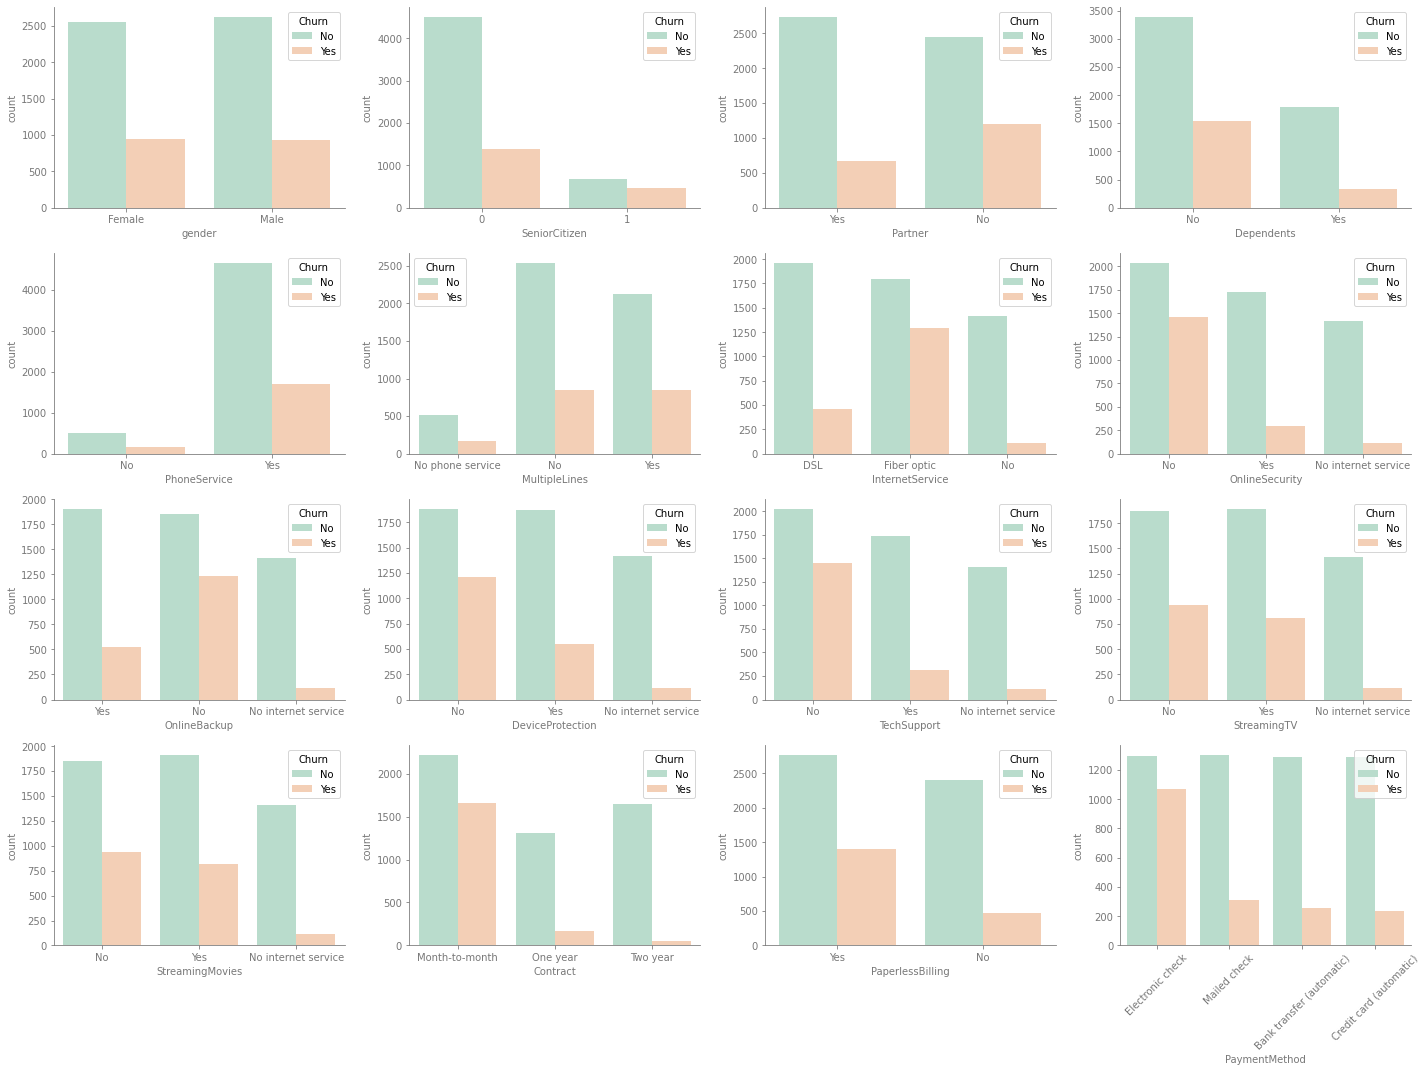

In [12]:
#Definindo os parâmetros de style para o matplotlib
rc_params = {'axes.edgecolor':'#787878', 
             'axes.titlecolor':'#787878', 
             'axes.labelcolor': '#787878', 
             'axes.spines.top':False, 
             'axes.spines.right': False, 
             'xtick.color': '#787878', 
             'ytick.color': '#787878',
             'axes.titleweight': 'bold',
             'axes.titlesize': 12,
             'axes.titlepad': 12
             }

#setando os parâmetros no matplotlib
with plt.rc_context(rc_params):

  #Instanciando a classe figure e axes
  fig, ax = plt.subplots(nrows = 4, ncols = 4, figsize = (20,15))

  #Definindo um contandor para pecorrer o axes
  cont_row = 0
  cont_col = 0

  #Criando um loop para gerar um gráfico de feature categórica com exceção do churn
  for cat_feature in df_var_trat["feature"].loc[(df_var_trat['Categórico'] == 1) & (df_var_trat['feature'] != "Churn") ].to_list():

    #Plotando um gráfico de contador para cada feature e separando por churn
    sns.countplot(x = cat_feature, data = df, ax = ax[cont_row, cont_col], hue = "Churn", palette = "Pastel2")

    #Definindo uma lógica de incremento nos contadores do axes
    if cont_col == 3:
      cont_col = 0
      cont_row = cont_row + 1
    else:
      cont_col = cont_col + 1

  #Rotaciona o eixo x da variável PaymentMethod
  plt.xticks(rotation = 45)

  #Exibindo o gráfico
  plt.tight_layout()

A partir dos gráficos, podemos concluir que:
* O gênero dos consumidores estão balanceados tanto em termos de quantidade de homens e mulheres quanto em quantidade de churn;
* Clientes que não são casados e não possuem dependentes tem maior probabilidade de abandonar os serviços;
* O pacote oferecido de internet gera uma maior probabilidade de clientes abandonarem o serviço. Como podermos observar, cliente que não possuem internet tendem a permanecer mais tempo com a empresa. Vale destacar também que os clientes buscam sempre pacotes que ofereçam o melhor custo benefício, por isso, quanto menor o benefício oferecido (backup online, suporte técnico, streaming e etc) menor as chances de reter o cliente;
* A qualidade do serviço deve ser considerada na estratégia de reter o cliente, pois podemos observar uma taxa de churn considerável para os consumidores que possuem streaming e internet de fibra ótica;
* Contratos de serviço mais arriscados (month-to-month) tendem a gerar uma taxa de churn maior;
* A forma de pagamento do tipo eletrônico check e cobrança de pagamento que não utilizam papel tende a aumentar a probabilidade de clientes abandonarem o serviço.

Vamos avaliar o histograma das variáveis numéricas com intuito de extrair alguns insights.

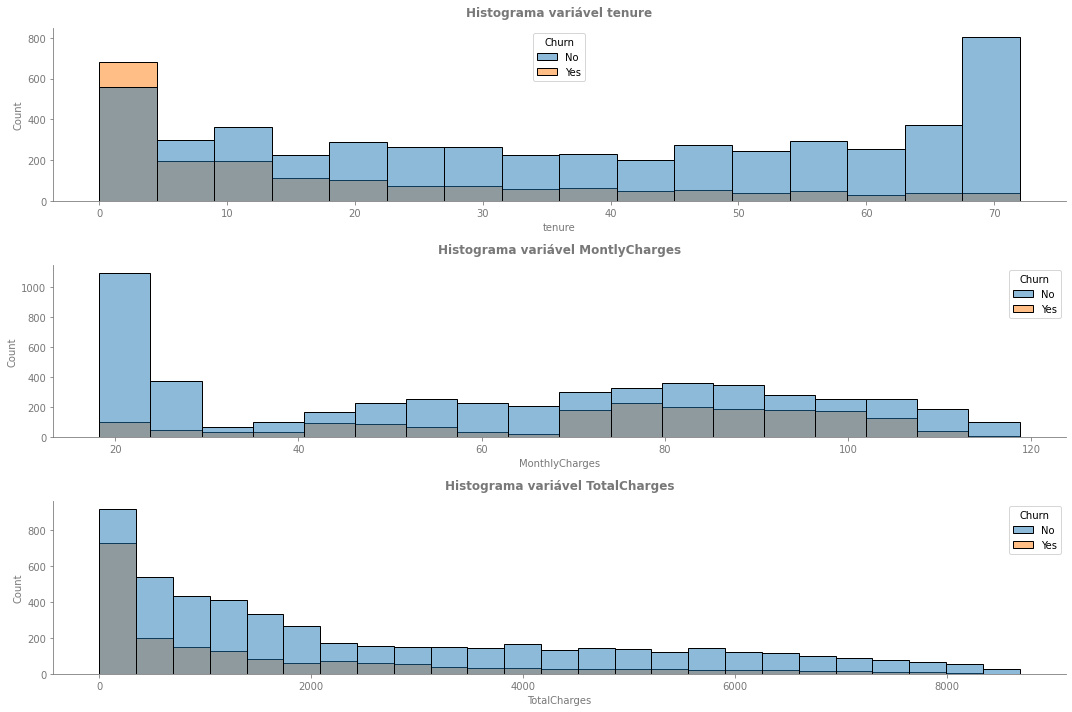

In [13]:
#setando os parâmetros no matplotlib
with plt.rc_context(rc_params):

  #Instanciando o objeto figure e axes
  fig, ax = plt.subplots( nrows = 3, ncols = 1, figsize = (15,10))

  #Criando um histograma para a variável tenure
  sns.histplot(data = df_trat, x = 'tenure', ax = ax[0], hue = "Churn")

  #Setando o título do gráfico
  ax[0].set_title("Histograma variável tenure")

  #Criando um histograma para variável MontlyCharges
  sns.histplot(data = df_trat, x = 'MonthlyCharges', ax = ax[1], hue = "Churn")

  #Setando o título do gráfico
  ax[1].set_title("Histograma variável MontlyCharges")

  #Criando um histograma para a variável TotalCharges
  sns.histplot(data = df_trat, x = 'TotalCharges', ax = ax[2], hue = "Churn")

  #Setando o título do gráfico
  ax[2].set_title("Histograma variável TotalCharges")

  #Exibindo o gráfico
  plt.tight_layout()

A partir dos histogramas, podemos notar que:
* As variáveis **tenure** e **TotalCharges** estão relacionadas indiretamente e transmitem o mesmo insight. Portanto, estas variáveis representam a fidelização do cliente, ou seja, quanto mais tempo uma pessoa for consumidora da empresa, maior a taxa de retenção do cliente;
* Quanto mais caro for a mensalidade pelo serviço, maior a chance de perder o cliente. Como havíamos comentado na análise das variáveis categóricas, os consumidores irão buscar sempre um serviço/produto que tenha o melhor custo e benefício.

 O próximo passo é avaliarmos se os dados estão balanceados em relação a variável alvo (Churn).

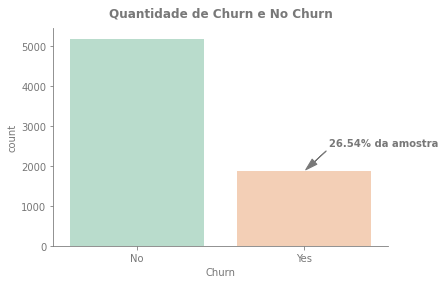

In [14]:
#setando os parâmetros no matplotlib
with plt.rc_context(rc_params):

  #Instanciando a Figure e Axes
  fig, ax = plt.subplots()

  #Criando o gráfico de countplot
  sns.countplot(x = 'Churn', 
                data = df_trat,
                ax = ax,
                palette = "Pastel2")
  
  #Exibindo o título
  ax.set_title("Quantidade de Churn e No Churn")

  #Armazena o % da amostra
  percentual_churn = round((df_trat['Churn'].value_counts()[1] / df_trat.shape[0])*100,2)

  #Criar uma informação no gráfico
  ax.annotate(str(percentual_churn) + "% da amostra", 
              xy = (1, df_trat['Churn'].value_counts()[1]), 
              xytext = (25,25), 
              color = "#787878",
              weight = 'bold', 
              textcoords='offset points',
              arrowprops=dict(color = '#787878',  shrink= 0.05, width = 0.01, headwidth = 7))

  #Exibindo o gráfico
  plt.show()

Como mostrado no gráfico, os dados relacionados com a variável alvo **Churn** está desbalanceada, visto que apenas 26,54% dos dados totais estão relacionados com consumidores que cancelaram o serviço.

Isto gera um problema durante a predição do modelo de Machine Learning, porque é mais cômodo para o algoritmo classificar a maioria dos casos como No Churn. Diante disto, será necessário balancear amostra. Este passo será mostrado e explicado durante a fase de preparação dos dados.

## Modelo de Machine Learning

Antes de iniciarmos qualquer processo para avaliar o melhor modelo de machine learning para o problema envolvendo churn prediction, temos que realizar uma preparação dos dados.

### Preparação dos dados

Nesta fase iremos preparar os dados para permitir que possamos aplicar os variados modelos de machine learning. Portanto, o primeiro passo é transformar as variáveis categóricas em valores numéricos.

Para isso, utilizaremos **LabelEncoder** da biblioteca do Scikit-Learn para transformar as variáveis binárias em valores de 0 e 1. Enquanto, para as variáveis que são categóricas e não binárias, utilizaremos o método **get_dummies** do Pandas que funciona de forma similar ao OneHotEncoder do Scikit-Learn com algumas facilidades para agilizar o processo.

Antes de iniciar o processo de feature engineering, vamos armazenar o nome das variáveis categóricas, binárias e numéricas em uma lista. Esta etapa facilitará tanto o processo de codificação quanto posteriormente quando aplicaremos a técnica de scaling feature nas variáveis numéricas.

In [15]:
#Armazenando as variáveis categóricas e não binárias
cat_features = df_var_trat['feature'].loc[ (df_var_trat['Categórico'] == 1) & (df_var_trat['Binário'] == 0) ].to_list()

#Armazenando as variáveis binárias
bin_features = df_var_trat['feature'].loc[ df_var_trat['Binário'] == 1 ].to_list()

#Armazenando as variáveis numéricas
num_features = df_var_trat['feature'].loc[ df_var_trat['Categórico'] == 0 ].to_list()

Com o nome das features armazenadas em listas de acordo com seu tipo, vamos aplicar as codificações nas variáveis categóricas e binárias. Vale destacar que devemos remover a variável **SeniorCitizen** por já estar codificada.

In [16]:
#Removendo a variável SeniorCitizen
bin_features.remove("SeniorCitizen")

#Instanciando a LabelEncorder
le = LabelEncoder()

#Aplicando o LabelEncoder no dataframe p/ var binárias
for bin_feature in bin_features:

  #Aplicando o método fit_transform para codificação
  df_trat[bin_feature] = le.fit_transform(df_trat[bin_feature])

#Aplicando o método get_dummies nas variáveis categóricas
df_trat = pd.get_dummies(data = df_trat, columns = cat_features)

Vamos avaliar como ficou o dataset tratado, imprimindo as 5 primeiras linhas.

In [17]:
#Imprimindo as 5 primeiras linhas
df_trat.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,0,0,1,0,1,0,0,0,1,0,0,0,0,1,29.85,29.85,0,1,0,0,1,0,0,0,0,1,0
1,5575-GNVDE,1,0,0,0,34,1,0,1,0,1,0,0,0,0,56.95,1889.50,0,1,0,0,0,1,0,0,0,0,1
2,3668-QPYBK,1,0,0,0,2,1,0,1,1,0,0,0,0,1,53.85,108.15,1,1,0,0,1,0,0,0,0,0,1
3,7795-CFOCW,1,0,0,0,45,0,0,1,0,1,1,0,0,0,42.30,1840.75,0,1,0,0,0,1,0,1,0,0,0
4,9237-HQITU,0,0,0,0,2,1,0,0,0,0,0,0,0,1,70.70,151.65,1,0,1,0,1,0,0,0,0,1,0


O próximo passo é dividirmos a base de dados entre treino e teste. Este passo é importante para ajustarmos os modelos de machine learning com base no dataset de treino, fazer todas as otimizações necessárias, escolher o melhor modelo com base na sua performance para que no final possamos validar o nível de generalização do modelo com base em um dataset com dados desconhecidos (teste).

Além disso, para podermos dividir os dados em treino e teste, precisamos definir os valores de X (variáveis independentes) e y (Churn - variável alvo).

Vale destacar que a variável **customerID**, como mencionado anteriormente, não agrega valor para o modelo. Portanto, iremos retirar do dataset.



In [18]:
#Definindo os valores de X e y
X = df_trat.drop(['customerID', 'Churn'], axis = 1)
y = df_trat['Churn']

#Dividindo o dataset em treino e test
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    shuffle = True, 
                                                    stratify = y,
                                                    random_state = 42)

O próximo passo é balancear os dados para evitar que a predição fique enviesada e limite a capacidade do modelo em generalizar.

Esta etapa pode ser feita por duas maneiras, conforme indicado por [Carlos Melo](https://sigmoidal.ai/como-lidar-com-dados-desbalanceados/):

>* Over-sampling: cria novas observações da classe minoritária a partir das informações contidas nos dados originais. Essa geração de novas entradas pode ser feita aleatoriamente com o auxílio de técnicas de clustering ou sinteticamente.
* Under-sampling: reduz o desbalanceamento do dataset focando na classe majoritária. Ou seja, elimina aleatoriamente entradas da classe com maior número de ocorrências.

Utilizaremos como base a técnica de **under-sampling**, devido a possibilidade de mantermos integralmente os dados originais associados a Churn.

In [19]:
#Instanciando o objeto RandomUnderSampler()
rus = RandomUnderSampler()

#Balanceando a amostra
X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

#Transformando o array X em dataframe e y em série
X_train_rus = pd.DataFrame(X_train_rus, columns = X_train.columns)
y_train_rus = pd.Series(y_train_rus)

### Escolha do Melhor Modelo

Com as preparações dos dados, é possível aplicar os variados modelos de machine learning em busca daquele que atende a melhor métrica de avaliação para este problema.

Portanto, a métrica de avaliação escolhida para definir a melhor modelo de acordo com a performance no dataset de validação é o **Recall**, porque para este problema queremos que o modelo seja capaz de maximizar os acertos de usuários possíveis de Churn, independente do erro.

Utilizaremos os seguintes modelos para ajuste e análise:

* Regressão Logística
* Random Forest
* SVC
* KNN
* XGBoost

Antes de iniciar o processo de definição do melhor estimador, vamos otimizar os hiperparâmetros de cada modelo em busca de maximizar os resultados individuais.

#### Otimização Hiperparâmetros
O próximo passo é otimizar os hiperparâmetros de cada modelo, por isso, utilizaremos o algoritmo **GridSearchCV** do Scikit-Learn que visa escolher o melhor conjunto de hiperparâmetros a partir de uma validação cruzada.

Antes de iniciarmos este processo, vamos instanciar e definir os parâmetros do Kfold para validação cruzada e criar um passo dentro do pipeline que definiremos para o GridSearchCV com o intuito de padronizar as variáveis numéricas. 

Vale destacar que é recomendado padronizar apenas as variáveis numéricas para trazer os valores para uma escala padrão, já que alguns modelos de machine learning baseados em distância e gradiente não funcionam de forma adequada para valores com escalas muitos diferentes, podendo gerar um erro na predição.

In [33]:
#Instanciando os parâmetros do Kfold para Validação Cruzada
k_fold = KFold(n_splits = 5, shuffle = True, random_state = 42)

In [34]:
#Escalonando as variáveis numéricas
num_scaled = ColumnTransformer([("Padronizar", StandardScaler(), num_features)],
                         remainder='passthrough')

##### Regressão Logística

O próximo passo é otimizar os hiperparâmetros para Regressão Logística. Iremos focar em três hiperparâmetros:
* Penalidade;
* Grau da penalidade (C);
* Solver mais adequado para otimização do modelo para este problema.

In [55]:
#Importando o algoritmo de regressão logística
from sklearn.linear_model import LogisticRegression

#Definindo os passos da pipeline
pipe = make_pipeline(num_scaled, LogisticRegression(random_state = 42))

#Definindo os parâmetros para simulação do GridSearch
param_grid = {"logisticregression__penalty": ['l1', 'l2', 'elasticnet', 'none'],
              "logisticregression__C": [100, 10, 1, 0, 0.1, 0.01],
              "logisticregression__solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

#Instanciando o GridSearch
clf = GridSearchCV(estimator = pipe,
                   param_grid = param_grid,
                   scoring = 'recall',
                   n_jobs = -1,
                   cv = k_fold)

#Ajustando com base no X_train e y_train balanceado
clf.fit(X = X_train_rus, 
        y = y_train_rus)

#Imprimindo o melhor parâmetro
clf.best_params_

{'logisticregression__C': 1,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'liblinear'}

De acordo com GridSearchCV, os parâmetros que mais se adequam ao modelo de regressão logística, levando em consideração as particularidades do problema, são:
* Penalidade = 'l2';
* C = 1;
* Solver = 'liblinear'.

##### Random Forest
O próximo passo é otimizar os hiperparâmetros para Random Forest. Iremos focar em dois hiperparâmetros:

* Máximo de features para dividir o nó em cada árvore (max_features);
* número de árovres (n_estimators).

In [60]:
#Importando o algoritmo de Random Forest
from sklearn.ensemble import RandomForestClassifier

#Definindo os passos da pipeline
pipe = make_pipeline(num_scaled, RandomForestClassifier(random_state = 42))

#Definindo os parâmetros para simulação do GridSearch
param_grid = {"randomforestclassifier__n_estimators": [10, 100, 1000],
              "randomforestclassifier__max_features": ['auto', 'sqrt', 'log2']}

#Instanciando o GridSearch
clf = GridSearchCV(estimator = pipe,
                   param_grid = param_grid,
                   scoring = 'recall',
                   n_jobs = -1,
                   cv = k_fold)

#Ajustando com base no X_train e y_train balanceado
clf.fit(X = X_train_rus, 
        y = y_train_rus)

#Imprimindo o melhor parâmetro
clf.best_params_

{'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__n_estimators': 1000}

De acordo com GridSearchCV, os parâmetros que mais se adequam ao modelo de Random Forest, levando em consideração as particularidades do problema, são:

* max_features = 'auto';
* n_estimators = 1000.

##### SVC
O próximo passo é otimizar os hiperparâmetros para SVC. Iremos focar em três hiperparâmetros:

* Kernel;
* Grau de penalização (C);
* Gamma.

In [61]:
#Importando o algoritmo de SVC
from sklearn.svm import SVC

#Definindo os passos da pipeline
pipe = make_pipeline(num_scaled, SVC(random_state = 42))

#Definindo os parâmetros para simulação do GridSearch
param_grid = {"svc__kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
              "svc__C": [100, 10, 1, 0, 0.1, 0.001],
              "svc__gamma": ['scale', 'auto']}

#Instanciando o GridSearch
clf = GridSearchCV(estimator = pipe,
                   param_grid = param_grid,
                   scoring = 'recall',
                   n_jobs = -1,
                   cv = k_fold)

#Ajustando com base no X_train e y_train balanceado
clf.fit(X = X_train_rus, 
        y = y_train_rus)

#Imprimindo o melhor parâmetro
clf.best_params_

{'svc__C': 0.001, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}

De acordo com GridSearchCV, os parâmetros que mais se adequam ao modelo de Random Forest, levando em consideração as particularidades do problema, são:

* C = 0.001;
* gamma = 'Scale';
* kernel = 'poly'. 

##### KNN
O próximo passo é otimizar os hiperparâmetros para KNN. Iremos focar em três hiperparâmetros:

* número de vizinhos (n_neighbors);
* pesos de cada ponto (weights);
* métrica de distância (metric).

In [65]:
#Importando o algoritmo de KNN
from sklearn.neighbors import KNeighborsClassifier

#Definindo os passos da pipeline
pipe = make_pipeline(num_scaled, KNeighborsClassifier())

#Definindo os parâmetros para simulação do GridSearch
param_grid = {"kneighborsclassifier__n_neighbors": [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
              "kneighborsclassifier__metric": ["euclidean", "manhattan", "minkowski"],
              "kneighborsclassifier__weights": ['uniform', 'distance']}

#Instanciando o GridSearch
clf = GridSearchCV(estimator = pipe,
                   param_grid = param_grid,
                   scoring = 'recall',
                   n_jobs = -1,
                   cv = k_fold)

#Ajustando com base no X_train e y_train balanceado
clf.fit(X = X_train_rus, 
        y = y_train_rus)

#Imprimindo o melhor parâmetro
clf.best_params_

{'kneighborsclassifier__metric': 'manhattan',
 'kneighborsclassifier__n_neighbors': 15,
 'kneighborsclassifier__weights': 'uniform'}

De acordo com GridSearchCV, os parâmetros que mais se adequam ao modelo de KNN, levando em consideração as particularidades do problema, são:

* metric = 'manhattan';
* n_neighbors = 15;
* weights = 'uniform'. 

##### XGBoost

O próximo passo é otimizar os hiperparâmetros para XGBoost. Iremos focar em quatro hiperparâmetros:

* Número de árvores (n_estimators);
* Taxa de aprendizagem (learning_rate);
* % do subconjunto de dados a serem considerados em cada árvore (subsample);
* Profundidade de cada árvore (max_depth).

In [66]:
#Importando o algoritmo de KNN
from xgboost import XGBClassifier

#Definindo os passos da pipeline
pipe = make_pipeline(num_scaled, XGBClassifier(random_state = 42))

#Definindo os parâmetros para simulação do GridSearch
param_grid = {"xgbclassifier__n_estimators": [10, 100, 1000],
              "xgbclassifier__learning_rate": [0.001, 0.01, 0.1],
              "xgbclassifier__subsample": [0.5, 0.7, 1],
              "xgbclassifier__max_depth": [3, 7, 9]}

#Instanciando o GridSearch
clf = GridSearchCV(estimator = pipe,
                   param_grid = param_grid,
                   scoring = 'recall',
                   n_jobs = -1,
                   cv = k_fold)

#Ajustando com base no X_train e y_train balanceado
clf.fit(X = X_train_rus, 
        y = y_train_rus)

#Imprimindo o melhor parâmetro
clf.best_params_

{'xgbclassifier__learning_rate': 0.1,
 'xgbclassifier__max_depth': 3,
 'xgbclassifier__n_estimators': 10,
 'xgbclassifier__subsample': 0.7}

De acordo com GridSearchCV, os parâmetros que mais se adequam ao modelo de XGboost, levando em consideração as particularidades do problema, são:

* learning_rate = 0.1;
* max_depth = 3;
* n_estimators = 10;
* subsample = 0.7. 

#### Definindo o melhor modelo

Após a otimização dos hiperparâmetros dos modelos escolhidos, vamos avaliar o melhor modelo com base na métrica **recall** obtida a partir do algoritmo de cross-validation do Scikit-learn.

In [74]:
#Criando uma lista vazia para armazenar os valores das métricas e o nome do modelo
name_model = []
recall = []

#Instanaciando os modelos com os hiperparâmetros otimizados
model_rl = LogisticRegression(C = 1, 
                              solver = "liblinear",
                              penalty = "l2",
                              random_state = 42)

model_rf = RandomForestClassifier(n_estimators = 1000,
                                  max_features = 'auto',
                                  random_state = 42)

model_svc = SVC(C = 0.001,
                kernel = 'poly',
                gamma = 'scale',
                random_state = 42)

model_knn = KNeighborsClassifier(n_neighbors = 15,
                                 metric = 'manhattan',
                                 weights = 'uniform')

model_xgb = XGBClassifier(learning_rate = 0.1,
                          max_depth = 3,
                          n_estimators = 10,
                          subsample = 0.7,
                          random_state = 42)

#Criando um loop para aplicar o cross_validation em cada modelo e armazenar o resultado
for model in [model_rl, model_rf, model_svc, model_knn, model_xgb]:

  #Criando um pipeline com a padronização + modelo
  pipe = make_pipeline(num_scaled, model)

  #Aplicando o cross_validation para calcular o score
  score = cross_val_score(estimator = pipe,
                          X = X_train_rus,
                          y = y_train_rus,
                          scoring = 'recall',
                          cv = k_fold)
  
  #Armazenando o nome do modelo
  name_model.append(model.__class__.__name__)

  #Armazenando o score do modelo
  recall.append(score.mean())

#Convertendo a estrutura de lista para um dataframe
df_model = pd.DataFrame(data = recall, 
                        index = name_model, 
                        columns = ['Recall'])

#Imprmindo a tabela de resultado
df_model

,Recall
LogisticRegression,0.799475
RandomForestClassifier,0.774495
SVC,0.913345
KNeighborsClassifier,0.839631
XGBClassifier,0.824419


A partir da validação cruzada, podemos notar que o modelo que melhor responde a métrica **recall** para o problema de Churn é o SVC. Porém, vamos testar mais um modelo que é resultante de uma combinação entre mais de um estimador.

Este modelo é chamado de **ensemble** e para possibilitar melhor utilização, temos que considerar modelos que se baseiam em técnicas diferentes para predizer a variável alvo. Portanto, iremos usar como base os seguintes modelos:
* Regressão logística - Gradiente Descendente;
* SVC - Encontra um hiperplano de separação entre as classes da variável alvo;
* KNN - Distância;
* XGBoost - Árvore de decisão.

In [76]:
#Importando a biblioteca do método ensemble
from sklearn.ensemble import VotingClassifier

#Armazenando os modelos
model_ensemble = [('rl', model_rl),
                  ('svc', model_svc),
                  ('knn', model_knn),
                  ('XGboost', model_xgb)]

#Instanciando o modelo ensemble
voting_clf = VotingClassifier( estimators = model_ensemble)

#Criando um pipeline com a padronização + modelo
pipe = make_pipeline(num_scaled, voting_clf)

#Aplicando o cross_validation para calcular o score
score = cross_val_score(estimator = pipe,
                        X = X_train_rus,
                        y = y_train_rus,
                        scoring = 'recall',
                        cv = k_fold)

#Armazenando o nome do modelo
name_model.append("Ensemble")

#Armazenando o resultado do score
recall.append(score.mean())

#Convertendo a estrutura de lista para um dataframe
df_model = pd.DataFrame(data = recall, 
                        index = name_model, 
                        columns = ['Recall'])

#Imprmindo a tabela de resultado
df_model

,Recall
LogisticRegression,0.799475
RandomForestClassifier,0.774495
SVC,0.913345
KNeighborsClassifier,0.839631
XGBClassifier,0.824419
Ensemble,0.817206


Mesmo com a adição do método ensemble, o modelo SVC ainda continua sendo o melhor modelo com base na métrica **recall**.
Portanto, o próximo passo é aplicarmos no dataset de teste para avaliarmos a capacidade de predição do modelo frente a dados desconhecidos.

### Avaliação do Modelo Escolhido nos Dados de Teste

O próximo passo é avaliarmos a performance do modelo escolhido em relação aos dados de teste.

              precision    recall  f1-score   support

           0       0.93      0.19      0.32      1294
           1       0.30      0.96      0.46       467

    accuracy                           0.40      1761
   macro avg       0.62      0.58      0.39      1761
weighted avg       0.76      0.40      0.36      1761

--------------------------------------------------------------------


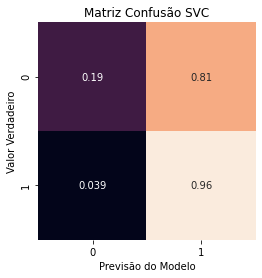

In [90]:
#Copiando o dataframe do X_train e X_test
X_train_rus_scaled = X_train_rus.copy()
X_test_scaled = X_test.copy()

#Padronizando as variáveis numéricas
for num_feature in num_features:

  #Instanciando o objeto de padronização
  scaler = StandardScaler()

  #Ajustando as variáveis numéricas do X_train
  X_train_rus_scaled[num_feature] = scaler.fit_transform(X_train_rus_scaled[num_feature].values.reshape(-1,1))

  #Ajustando as variáveis numéricas de X_test com os mesmos parâmetros do X_train
  X_test_scaled[num_feature] = scaler.transform(X_test_scaled[num_feature].values.reshape(-1,1))

#Instanciando novamente o modelo escolhido
model_svc = SVC(C = 0.001,
                kernel = 'poly',
                gamma = 'scale',
                random_state = 42)

#Aplicando o modelo escolhido
model_svc.fit(X = X_train_rus_scaled,
              y = y_train_rus)

#Fazendo a previsão com base nos dados de teste
y_pred = model_svc.predict(X_test_scaled)

# Classification Report
print(classification_report(y_test, y_pred))


print("--------------------------------------------------------------------")

#Instanciando a figure e axes
fig, ax = plt.subplots()

#Plotando a matriz de confusão em um heatmap
sns.heatmap(confusion_matrix(y_test, y_pred, normalize = 'true'), 
            square=True, 
            annot=True, 
            cbar=False,
            ax = ax)

#Definindo o nome do eixo x
ax.set_xlabel("Previsão do Modelo")

#Definindo o nome do eixo y
ax.set_ylabel("Valor Verdadeiro")

#Definindo o título
ax.set_title("Matriz Confusão SVC")

#Exibindo a matriz de confusão
plt.show()

## Conclusão
O modelo de machine learning escolhido se baseou na métrica **recall** com o intuito de acertar o máximo de Churn em clientes que realmente cancelaram o serviço com a empresa de telecomunicações.

Diante disto, o modelo que melhor se adequou foi o SVC, alcançando um **recall** na validação cruzada de 91%. Vale destacar também que seu resultado no dataset de teste (96%) foi próximo ao de validação.

Com estas informações, é possível a empresa prever dentre aos novos dados de consumidores quais podem cancelar o serviço e buscar estratégias que antecipem e contribuam para reter e fidelizar o cliente.